In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow.keras.utils as utils
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten, BatchNormalization, Dropout, ReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from time import perf_counter
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import gc
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras import applications
from tensorflow.keras import layers

In [2]:
import tensorflow as tf

print(tf.__version__)

2.10.0


In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8456745602212097759
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6243221504
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6735441799839758103
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 6242172928
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 727245900040359808
 physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:b3:00.0, compute capability: 7.5"
 xla_global_id: 2144165316]

In [4]:
image_directory = 'D:/19기 인턴 multi-label 데이터셋/Data_folder/'

#Now let us read metadata to get our Y values (multiple lables)

df = pd.read_csv('D:/crack_final.csv')
   
print(df.head())     # printing first five rows of the file
print(df.columns)
print(df.shape)

           ID  101  102  103  104
0  train_img1    1    0    0    0
1  train_img3    1    1    1    0
2  train_img4    1    1    0    0
3  train_img5    0    1    0    0
4  train_img6    1    0    0    0
Index(['ID', '101', '102', '103', '104'], dtype='object')
(26952, 5)


In [5]:
X_dataset= []  

for i in tqdm(range(df.shape[0])):
    img = image.load_img(image_directory +df['ID'][i]+'.jpg', target_size=(224,224,3))
    img = image.img_to_array(img)
    img = img/255.
    X_dataset.append(img)
    
X = np.array(X_dataset)

#Id and Genre are not labels to be trained. So drop them from the dataframe.
#No need to convert to categorical as the dataset is already in the right format.
y = np.array(df.drop(['ID'], axis=1))

100%|████████████████████████████████████████████████████████████████████████████| 26952/26952 [49:35<00:00,  9.06it/s]


In [6]:
Batch_size = 8

cos_decay_wr = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=0.0001,first_decay_steps=10,
    t_mul=2.0,m_mul=0.7, name=None)

SGDWR = tfa.optimizers.SGDW(weight_decay = 0.001,momentum = 0.9, nesterov = False)

SGDR = tf.keras.optimizers.SGD(momentum=0.9)

AdamR = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-07)

AdamWR = tfa.optimizers.AdamW(
    weight_decay=0.025, beta_1=0.9, beta_2=0.999)

Epochs = 30

Random_state = 42

tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=False,
    alpha=0.25,
    gamma=2.0,
    from_logits=True,
    name='binary_focal_crossentropy'
)

IMAGE_SIZE = (224,224)

In [7]:
X_train, x_test, Y_train, y_test = train_test_split(X, y, random_state = Random_state, test_size = 0.2)

In [8]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, random_state = Random_state, test_size = 0.125)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.1,
        shear_range=0.1,
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
)

In [10]:
datagen.fit(x_train)
train_datagen = datagen.flow(x_train, y_train, batch_size=Batch_size)

In [11]:
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.45)(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
predictions = Dense(4, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs = predictions)

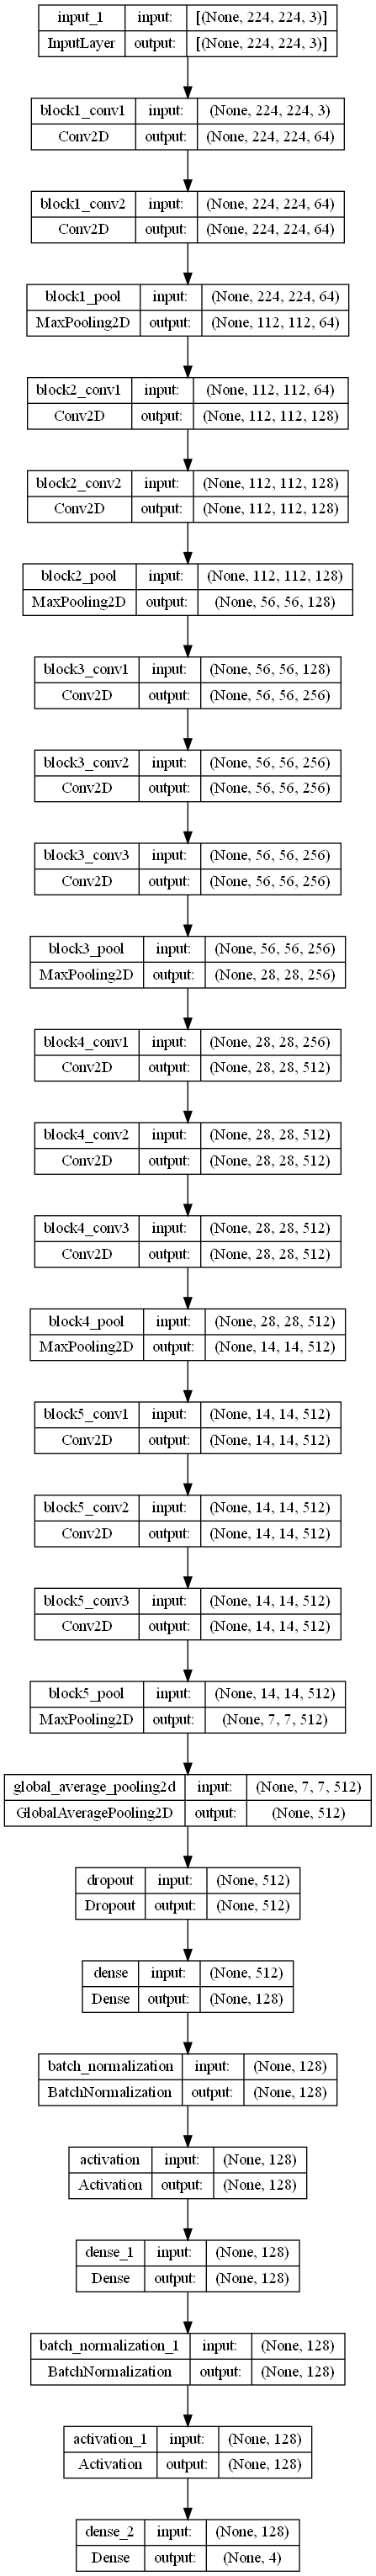

In [13]:
from tensorflow.keras.utils import plot_model
%matplotlib inline
plot_model(model, show_shapes=True)

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint
modelcheckpoint = ModelCheckpoint('VGG16_01_06_imagenet_final.h5', monitor='val_loss', mode='min', save_best_only=True)

In [15]:
class lrHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        self.lr = []
        
    def on_epoch_begin(self, epoch, logs):
        self.lr.append(tf.keras.backend.get_value(self.model.optimizer.lr))

lrhistory = lrHistory()

In [16]:
lr_scheduler = LearningRateScheduler(cos_decay_wr, verbose=1)

In [17]:
import gc
gc.collect()

7851

In [18]:
model.compile(optimizer=AdamR,loss='binary_crossentropy', metrics=['accuracy'])
history1 = model.fit(train_datagen, validation_data=(x_val,y_val),epochs=Epochs, callbacks=[lr_scheduler,modelcheckpoint])


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/30
2359/2359 [==============================] - 305s 121ms/step - loss: 0.5613 - accuracy: 0.4676 - val_loss: 0.5873 - val_accuracy: 0.4952 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.75528237177059e-05.
Epoch 2/30
2359/2359 [==============================] - 287s 122ms/step - loss: 0.4820 - accuracy: 0.5057 - val_loss: 0.4548 - val_accuracy: 0.4555 - lr: 9.7553e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.045084152603522e-05.
Epoch 3/30
2359/2359 [==============================] - 288s 122ms/step - loss: 0.4383 - accuracy: 0.4999 - val_loss: 0.4431 - val_accuracy: 0.4848 - lr: 9.0451e-05

Epoch 4: LearningRateScheduler setting learning rate to 7.938926137285307e-05.
Epoch 4/30
2359/2359 [==============================] - 288s 122ms/step - loss: 0.4180 - accuracy: 0.4893 - val_loss: 0.3936 - val_accuracy: 0.4826 - lr: 7.9389e-05

Epoch 5: LearningRat

In [19]:
pd.DataFrame.from_dict(history1.history).to_csv('VGG16_01_06_imagenet_final.csv',index=False)
# 파일명 :  모델명_날짜_가중치사용여부.csv

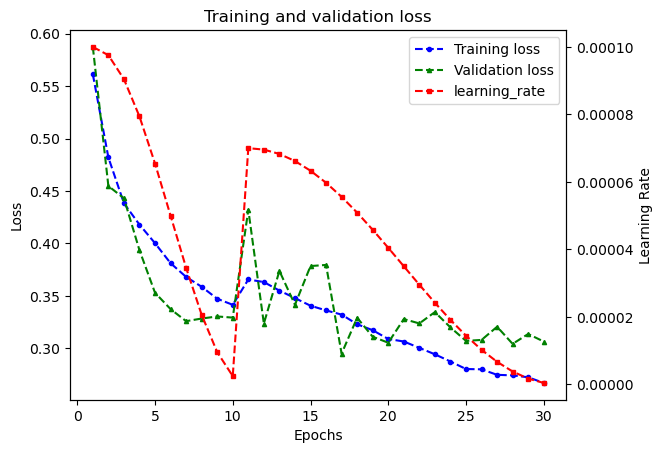

In [20]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
epochs = range(1, Epochs + 1)
loss = history1.history['loss']
val_loss = history1.history['val_loss']
lr = history1.history['lr']

line1 = ax1.plot(epochs, loss, color='b', linestyle='--', marker='o', label = 'Training loss',markersize=3)
line2 = ax1.plot(epochs, val_loss, color='g', linestyle='--', marker='^', label='Validation loss',markersize=3)
line3 = ax2.plot(epochs, lr, color = 'r', linestyle='--', marker='s', label = 'learning_rate',markersize=3)

#plt.plot(epochs, loss, 'y', label='Training loss')
#plt.plot(epochs, val_loss, 'r', label='Validation loss')
#plt.plot(epochs,lr, 'b', label='Learning_rate')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax2.set_ylabel('Learning Rate')

plt.legend(bbox_to_anchor=(1,1))

lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, loc=1)
plt.show()

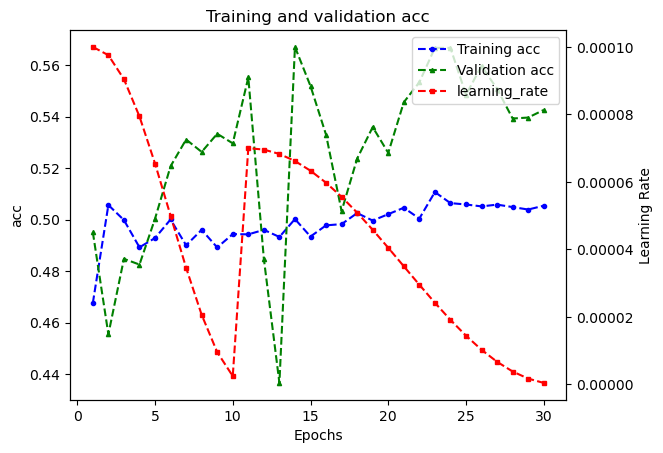

In [21]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

line1 = ax1.plot(epochs, acc, color='b', linestyle='--', marker='o', label = 'Training acc', markersize=3)
line2 = ax1.plot(epochs, val_acc, color='g', linestyle='--', marker='^', label='Validation acc', markersize=3)
line3 = ax2.plot(epochs, lr, color = 'r', linestyle='--', marker='s', label = 'learning_rate' , markersize=3)

#plt.plot(epochs, acc, 'y', label='Training acc')
#plt.plot(epochs, val_acc, 'r', label='Validation acc')
#plt.plot(epochs,lr, 'b', label='Learning_rate')
#plt.title('Training and validation accuracy')
#plt.xlabel('Epochs')
#plt.ylabel('Accuracy')
ax1.set_title('Training and validation acc')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('acc')
ax2.set_ylabel('Learning Rate')
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, loc=1)
plt.show()

In [22]:
gc.collect()

6592

In [27]:
best_model = tf.keras.models.load_model('VGG16_01_06_imagenet_final.h5')

In [28]:
with tf.device('device:GPU:1'):
    y_pred2 = best_model.predict(x_test)

169/169 [==============================] - 17s 97ms/step


In [23]:
with tf.device('device:GPU:1'):
    y_pred = model.predict(x_test)

169/169 [==============================] - 23s 103ms/step


In [24]:
threshold = 0.5
y_new_pred=[]
for sample in  y_pred:
    y_new_pred.append([1 if i>=0.5 else 0 for i in sample ] )
y_new_pred = np.array(y_new_pred)
y_new_pred

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 1, 0, 0],
       ...,
       [1, 1, 0, 0],
       [1, 1, 0, 1],
       [1, 1, 1, 0]])

In [29]:
threshold = 0.5
y_new_pred2=[]
for sample in  y_pred2:
    y_new_pred2.append([1 if i>=0.5 else 0 for i in sample ] )
y_new_pred2 = np.array(y_new_pred2)
y_new_pred2

array([[1, 1, 0, 0],
       [1, 1, 0, 0],
       [1, 1, 0, 0],
       ...,
       [1, 1, 0, 0],
       [0, 1, 0, 1],
       [1, 1, 1, 0]])

In [25]:
from sklearn.metrics import classification_report

label_names = ['101', '102', '103', '104']

print(classification_report(y_test, y_new_pred,target_names=label_names,digits=3))

              precision    recall  f1-score   support

         101      0.680     0.858     0.759      2430
         102      0.935     0.969     0.951      4832
         103      0.870     0.890     0.880      2564
         104      0.870     0.922     0.895      1959

   micro avg      0.850     0.921     0.884     11785
   macro avg      0.839     0.910     0.871     11785
weighted avg      0.857     0.921     0.887     11785
 samples avg      0.855     0.919     0.867     11785



C:\Users\PIAI\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PIAI\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
from sklearn.metrics import classification_report

label_names = ['101', '102', '103', '104']

print(classification_report(y_test, y_new_pred2,target_names=label_names,digits=3))

              precision    recall  f1-score   support

         101      0.788     0.730     0.758      2430
         102      0.924     0.978     0.951      4832
         103      0.886     0.854     0.870      2564
         104      0.874     0.917     0.895      1959

   micro avg      0.882     0.890     0.886     11785
   macro avg      0.868     0.870     0.868     11785
weighted avg      0.880     0.890     0.884     11785
 samples avg      0.885     0.899     0.872     11785



C:\Users\PIAI\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PIAI\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
import numpy as np
from sklearn.preprocessing import Binarizer
from sklearn.metrics import classification_report

thresholds_1 = [0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.50,]
thresholds_2 = [0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61]
def get_eval_by_threshold(y_test, y_pred, thresholds):
  # thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행
  for custom_threshold in thresholds_1:
    binarizer = Binarizer(threshold=custom_threshold).fit(y_pred)
    custom_predict = binarizer.transform(y_pred)
    print("\n임곗값 :", custom_threshold)
    print(classification_report(y_test, custom_predict,digits=3))

get_eval_by_threshold(y_test, y_pred, thresholds_1)

C:\Users\PIAI\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PIAI\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PIAI\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PIAI\anaconda3\envs\tf\lib\site-p


임곗값 : 0.41
              precision    recall  f1-score   support

           0      0.647     0.886     0.748      2430
           1      0.929     0.980     0.953      4832
           2      0.845     0.911     0.877      2564
           3      0.861     0.931     0.895      1959

   micro avg      0.830     0.937     0.880     11785
   macro avg      0.820     0.927     0.868     11785
weighted avg      0.841     0.937     0.885     11785
 samples avg      0.839     0.935     0.865     11785


임곗값 : 0.42
              precision    recall  f1-score   support

           0      0.651     0.883     0.750      2430
           1      0.929     0.978     0.953      4832
           2      0.847     0.907     0.876      2564
           3      0.862     0.930     0.895      1959

   micro avg      0.832     0.935     0.881     11785
   macro avg      0.823     0.925     0.868     11785
weighted avg      0.843     0.935     0.885     11785
 samples avg      0.841     0.933     0.865     11785

C:\Users\PIAI\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PIAI\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PIAI\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PIAI\anaconda3\envs\tf\lib\site-p



임곗값 : 0.49
              precision    recall  f1-score   support

           0      0.675     0.860     0.756      2430
           1      0.933     0.969     0.951      4832
           2      0.868     0.892     0.880      2564
           3      0.870     0.922     0.895      1959

   micro avg      0.847     0.922     0.883     11785
   macro avg      0.836     0.911     0.871     11785
weighted avg      0.855     0.922     0.886     11785
 samples avg      0.853     0.920     0.866     11785


임곗값 : 0.5
              precision    recall  f1-score   support

           0      0.680     0.858     0.759      2430
           1      0.935     0.969     0.951      4832
           2      0.870     0.890     0.880      2564
           3      0.870     0.922     0.895      1959

   micro avg      0.850     0.921     0.884     11785
   macro avg      0.839     0.910     0.871     11785
weighted avg      0.857     0.921     0.887     11785
 samples avg      0.855     0.919     0.867     11785

C:\Users\PIAI\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PIAI\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
